Load libraries

In [75]:
import pandas as pd
import numpy as np
import random

import os

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

import keras
from keras import backend as K

Set working directory

In [149]:
%cd /content/drive/My Drive/IESEG/SML/data/bankruptcy_prediction

/content/drive/My Drive/IESEG/SML/data/bankruptcy_prediction


Data prep

In [77]:
# Load data
data = pd.read_csv("data.csv")

In [78]:
#check sample data
data.head(3)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [79]:
# list column names
data.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [80]:
# Check for na's
data.isna().sum().sum()

0

In [81]:
#!pip install shutup

In [82]:
import shutup
shutup.please()

# clean some of the column names
data.columns = data.columns.str.replace("?","")
data.columns = data.columns.str.replace("(","_")
data.columns = data.columns.str.replace(")","")

In [83]:
data.columns

Index(['Bankrupt', ' ROA_C before interest and depreciation before interest',
       ' ROA_A before interest and % after tax',
       ' ROA_B before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate _after tax', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate _A',
       ' Net Value Per Share _B', ' Net Value Per Share _A',
       ' Net Value Per Share _C', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share _Yuan ¥',
       ' Operating Profit Per Share _Yuan ¥',
       ' Per Share Net profit before tax _Yuan ¥',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit Growth Rate

In [84]:
# check for any empty rows
data.isna().sum(axis=1).sum()

0

In [85]:
# seperate IV  from DV
X = data.drop(['Bankrupt'],axis = 1)
y = data.pop('Bankrupt')

In [86]:
# Create train test split
X_train, X_test, y_train,y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=1,
                                    shuffle=True)

In [87]:
y_train.value_counts(1)

0    0.967736
1    0.032264
Name: Bankrupt, dtype: float64

In [88]:
# Scale the test and train data
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [89]:
# change scaled data back to df
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Feature selection

In [90]:
# use random forest for feature selecton
sel = SelectFromModel(RandomForestClassifier(n_estimators = 300, max_depth=90))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=90,
                                                 n_estimators=300))

In [91]:
# assign important features that random forest gave to a list to use later
selected_feat= X_train.columns[(sel.get_support())]

#compare length of selected features with original column length
print("Columns before: ", len(X_train.columns), "| Columns after: ", len(selected_feat))

Columns before:  95 | Columns after:  39


In [92]:
selected_feat

Index([' ROA_C before interest and depreciation before interest',
       ' ROA_A before interest and % after tax',
       ' ROA_B before interest and depreciation after tax',
       ' Pre-tax net Interest Rate', ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate _after tax', ' Net Value Per Share _B',
       ' Net Value Per Share _A', ' Net Value Per Share _C',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax _Yuan ¥',
       ' Operating Profit Growth Rate', ' Interest Expense Ratio',
       ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Inventory and accounts receivable/Net value',
       ' Operating profit per person', ' Working Capital to Total Assets',
       ' Quick Assets/Total Assets', ' Cash/Total Assets',
       ' Current Liability to Assets', ' Inventory/Working Capital',
       ' Working Cap

Neural Network with 1 layer and 30 neuron

In [93]:
#set length of columns as input shape
n_cols = X_train[selected_feat].shape[1]

In [94]:
# set up early stopping
early_stop =  EarlyStopping(mode='max', verbose=1, patience=22)

In [95]:
# initialize the model
model =  Sequential()

In [96]:
# Set up evaluation metrics
def auc(y_true, y_pred):
    auc = tf.metrics.AUC(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [97]:
# set up the layers
nn_one_layer = tf.keras.Sequential()
nn_one_layer.add(tf.keras.layers.Dense(30, input_shape=(n_cols,),  activation='sigmoid'))
#nn_one_layer.add(tf.keras.layers.Dense(2))

#compile the model
nn_one_layer.compile(optimizer='Adam', loss='mse')

In [98]:
nn_one_layer.layers

In [99]:
# Train model
nn_one_layer.fit(x=X_train[selected_feat], 
          y=y_train, 
          epochs=30,
          validation_data=(X_test[selected_feat], y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/30
171/171 [==============================] - 1s 3ms/step - loss: 0.2409 - val_loss: 0.2123
Epoch 2/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1930 - val_loss: 0.1757
Epoch 3/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1612 - val_loss: 0.1482
Epoch 4/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1362 - val_loss: 0.1269
Epoch 5/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1163 - val_loss: 0.1092
Epoch 6/30
171/171 [==============================] - 0s 2ms/step - loss: 0.1005 - val_loss: 0.0956
Epoch 7/30
171/171 [==============================] - 0s 2ms/step - loss: 0.0878 - val_loss: 0.0846
Epoch 8/30
171/171 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0762
Epoch 9/30
171/171 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0691
Epoch 10/30
171/171 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0635

In [100]:
print(nn_one_layer.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 30)                1200      
                                                                 
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________
None


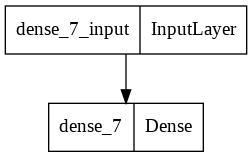

In [101]:
tf.keras.utils.plot_model(
    nn_one_layer
)

In [102]:
performances = {}
# save evaluation results to compare later
probabilities   = pd.DataFrame(nn_one_layer.predict(X_test[selected_feat]))
predictions = np.where(probabilities[1]> 0.5, 1, 0)

nn_one_layer_auc = roc_auc_score(y_test.values, probabilities[1].values)
nn_one_layer_accuracy = accuracy_score(y_test.values, predictions)

performances["nn_one_layer"] = {"Accuracy":nn_one_layer_auc,"AUC":nn_one_layer_accuracy}

Neural network with multiple hidden layers (Deep Neural network)

In [103]:
# set up neural network layers
nn_multi_layer = tf.keras.Sequential()
nn_multi_layer.add(tf.keras.layers.Dense(n_cols,  activation='sigmoid'))
nn_multi_layer.add(tf.keras.layers.Dense(np.round(n_cols*1.3), activation='sigmoid'))
nn_multi_layer.add(tf.keras.layers.Dense(30))
nn_multi_layer.add(tf.keras.layers.Dense(25))
nn_multi_layer.add(tf.keras.layers.Dense(10, activation='sigmoid'))
nn_multi_layer.add(tf.keras.layers.Dense(2))
nn_multi_layer.compile(optimizer='Adam', loss='mse')

In [104]:
# Train the model
nn_multi_layer.fit(x=X_train[selected_feat], 
          y=y_train, 
          epochs=30,
          validation_data=(X_test[selected_feat], y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/30
171/171 [==============================] - 1s 4ms/step - loss: 0.0546 - val_loss: 0.0290
Epoch 2/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0282 - val_loss: 0.0281
Epoch 3/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0280
Epoch 4/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0286
Epoch 5/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0257 - val_loss: 0.0285
Epoch 6/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0268
Epoch 7/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0262
Epoch 8/30
171/171 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0262
Epoch 9/30
171/171 [==============================] - 1s 4ms/step - loss: 0.0241 - val_loss: 0.0262
Epoch 10/30
171/171 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0266

In [145]:
print(nn_multi_layer.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 39)                1560      
                                                                 
 dense_9 (Dense)             (None, 51)                2040      
                                                                 
 dense_10 (Dense)            (None, 30)                1560      
                                                                 
 dense_11 (Dense)            (None, 25)                775       
                                                                 
 dense_12 (Dense)            (None, 10)                260       
                                                                 
 dense_13 (Dense)            (None, 2)                 22        
                                                                 
Total params: 6,217
Trainable params: 6,217
Non-traina

In [105]:
# save performance to compare later
probabilities   = pd.DataFrame(nn_multi_layer.predict(X_test[selected_feat]))
predictions = np.where(probabilities[1]> 0.5, 1, 0)

nn_multi_layer_auc = roc_auc_score(y_test.values, probabilities[1].values)
nn_multi_layer_accuracy = accuracy_score(y_test.values, predictions)

performances["nn_multi_layer"] = {"Accuracy":nn_multi_layer_auc,"AUC":nn_multi_layer_accuracy}

Run additional classification models for comparison

In [106]:
logistic     = LogisticRegression(max_iter = 2000)
tree         = DecisionTreeClassifier()
randomForest = RandomForestClassifier(max_depth=8, n_estimators=100)
boostedTree  = GradientBoostingClassifier(n_estimators=120)
XG           = XGBClassifier(max_depth=8, n_estimators=125)
KNN          = KNeighborsClassifier(n_neighbors=25)
DT           = DecisionTreeClassifier()
ADABoost     = AdaBoostClassifier()

# create a dict to loop through the models
models = {
          "logistic"     :logistic,
          "tree"         :tree,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "XG"           :XG,
          "KNN"          :KNN,
          "ADABoost"     :ADABoost         }

In [107]:
# fit the models
shutup.please()
for model in models:
    random.seed=1
    models[model].fit(X_train[selected_feat], y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
tree has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
XG has been trained successfully
KNN has been trained successfully
ADABoost has been trained successfully


In [108]:
for model in models:
    random.seed=1
    predictions   = models[model].predict(X_test[selected_feat])
    probabilities = pd.DataFrame(models[model].predict_proba(X_test[selected_feat]))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(np.array(y_test),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

Compare models

In [109]:
evaluation = pd.DataFrame(performances).transpose().sort_values(by=["AUC","Accuracy"], ascending=False).T

In [144]:
evaluation

,nn_multi_layer,nn_one_layer,ADABoost,XG,boostedTree,logistic,randomForest,KNN,tree
Accuracy,0.919456,0.859504,0.969208,0.970674,0.969941,0.967742,0.969941,0.969208,0.956012
AUC,0.969208,0.963343,0.941615,0.933127,0.931104,0.926446,0.914652,0.837767,0.625758


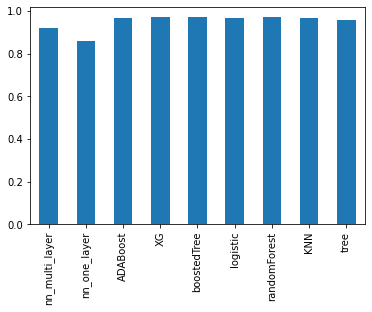

In [143]:
evaluation.loc["Accuracy"].plot(kind="bar", use_index=True)

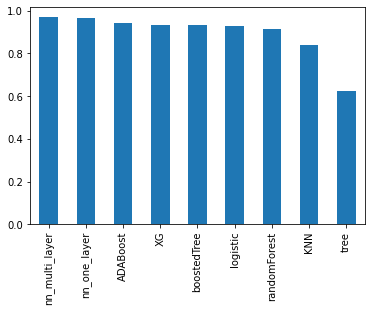

In [140]:
evaluation.loc["AUC"].plot(kind="bar", use_index=True)